# Q learning

Датасет - https://www.kaggle.com/datasets/billqi/binance-bitcoin-futures-price-10s-intervals?resource=download

Разработаем алгоритм, определяющий, в какие моменты стоит продавать и покупать биткоин

## Импортируем необходимые библиотеки

In [ ]:
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import os

## Загружаем данные

In [ ]:
prices = np.loadtxt('/content/prices_btc_Jan_11_2020_to_May_22_2020.txt', dtype=float)
print('Кол-во записей:', len(prices))

FileNotFoundError: ignored

In [ ]:
fig = go.Figure(data=go.Scatter(y=prices[-10000:]))
fig.update_layout(
    title="Стоимость Btc в $ по времени",
    xaxis_title="время",
    yaxis_title="$"
)
fig.show()

NameError: ignored

# Информация по реализации алгоритма

Обучим Q-Learning для торговли биткоинами. Q-Learning является методом обучения с подкреплением, где агент принимает решения, основываясь на текущем состоянии и ожидаемой награде.

Агент, Среда, Действия, Состояние, Награда, Политика

* Агент: Наш торговый агент, который принимает решение о покупке, продаже или удержании биткоина.
* Среда: Исторические данные о цене биткоина.
* Действия: Купить, продать или ничего не делать.
* Состояние: Текущая цена биткоина, количество биткоина и денег у агента.
* Награда: Если после выполнения действия у нас стало больше денег или биткоинов, агент получает награду.
* Политика: Стратегия, по которой агент выбирает действие (например, исследование или эксплуатация на основе Q-таблицы).

## Что есть Q-Learning?

Q-Learning работает путем итеративного обновления Q-значения для пары (состояние, действие). Q-значение представляет собой оценку ожидаемой награды при выполнении определенного действия в данном состоянии и далее следования оптимальной политике.

Обновление Q-значения выполняется с использованием следующей формулы:

$Q(state,action)=Q(state,action)+α⋅(reward+γ⋅maxQ(next_state,action)−Q(state,action))$

где:

* $α$ — скорость обучения.
* $γ$ — коэффициент дисконтирования, определяющий важность будущих наград.
* $maxQ(next_state,action)$ — максимальное Q-значение для следующего состояния.





*Обратите внимание, что данный подход является дискретным и зависит от исторических данных, поэтому его не следует использовать для реальной торговли без дополнительных тестов и адаптаций.*

## Реализация

Определим возможные действия - покупка, продажа, ничего не делать. <br />
При покупке на все имеющиеся деньги покупаем весь возможный биткоин, обновляем состояния имеющихся биткоинов и денег, при продаже продаем весь биткоин и обновляем состояния.
Для того, чтоб выполнить действие необходимо знать текущую цену, текущие состояния денег и биткоинов

In [ ]:
def buy(btc_price, btc, money):
    if(money != 0):
        btc = (1 / btc_price ) * money
        money = 0
    return btc, money


def sell(btc_price, btc, money):
    if(btc != 0):
        money = btc_price * btc
        btc = 0
    return btc, money


def wait(btc_price, btc, money):
    return btc, money

In [ ]:
np.random.seed(1)

# Определяем возможные действия и инициализируем Q-таблицу, исходя из действий и состояний (различных значений цены)
actions = { 'buy' : buy, 'sell': sell, 'wait' : wait}

actions_to_nr = { 'buy' : 0, 'sell' : 1, 'wait' : 2 }
nr_to_actions = { k:v for (k,v) in enumerate(actions_to_nr) }


# Инициализация Q-таблицы
nr_actions = len(actions_to_nr.keys())
nr_states = len(prices)

q_table = np.random.rand(nr_states, nr_actions)

Определим функцию награды. Награда есть, если у нас стало больше денег или биткоинов.
Важно: в данном случае награда не учитывает, сколько в деньгах мы выиграли, только есть выигрыш или нет

In [ ]:
def get_reward(before_btc, btc, before_money, money, state, prices):
    reward = 0

    sum_waller_before = before_money + before_btc * prices[state-1]
    sum_waller = money + btc * prices[state]

    if (sum_waller > sum_waller_before):
        reward = 1
    elif (sum_waller < sum_waller_before):
      reward = -1
    else:
      reward = 0
    return reward


# def get_reward(before_btc, btc, before_money, money):
#     reward = 0
#     if(btc != 0):
#         if(before_btc < btc):
#             reward = 1
#     if(money != 0):
#         if(before_money < money):
#             reward = 1
#     print(state, reward)
#     return reward

Определим функцию, выбирающую действие, в зависимости от состояния. Иногда оно будет выбираться случайно, иногда, исходя из q-таблицы

In [ ]:
def choose_action(state):
    if np.random.uniform(0, 1) < eps:
        return np.random.randint(0, 2)
    else:
        return np.argmax(q_table[state])

In [ ]:
def take_action(state, action):
    return actions[nr_to_actions[action]](prices[state], btc, money)

Определим функцию для выполнения следующего действия

In [ ]:
def act(state, action, theta, prices):
    btc, money = theta

    done = False
    new_state = state + 1

    before_btc, before_money = btc, money
    btc, money = take_action(state, action)
    theta = btc, money

    #reward = get_reward(before_btc, btc, before_money, money)
    if(new_state == nr_states):
        done = True

    reward = get_reward(before_btc, btc, before_money, money, state, prices)
    return new_state, reward, theta, done

Определим изначальные состояния и гиперпараметры обучения

In [ ]:
reward = 0
btc = 0
money = 100

theta = btc, money

In [ ]:
# Для большей вариативности
eps = 0.3

# Сколько раз мы пройдемся по датасету
n_episodes = 20
min_alpha = 0.02

# learning rate
alphas = np.linspace(1.0, min_alpha, n_episodes)

# Для баланса немедленной и долгосрочной наград
gamma = 1.0


- Начинаем в состоянии 0
- Выбираем действие
- Обновляем таблицу

### Обучение агента

In [ ]:
rewards = {}
for e in range(n_episodes):
    # Снижаем случайность по мере обучения модели
    total_reward = 0

    state = 0
    done = False
    alpha = alphas[e]

    while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta, prices)

        total_reward += reward

        if(done):
            rewards[e] = total_reward
            print(f"Episode {e + 1}: total reward -> {total_reward}")
            break

        q_table[state][action] = q_table[state][action] + alpha * (reward + gamma *  np.max(q_table[next_state]) - q_table[state][action])

        state = next_state

Episode 1: total reward -> -92
Episode 2: total reward -> 1211
Episode 3: total reward -> 1186
Episode 4: total reward -> 1519
Episode 5: total reward -> 1645
Episode 6: total reward -> 1885
Episode 7: total reward -> 2162
Episode 8: total reward -> 2171
Episode 9: total reward -> 2312
Episode 10: total reward -> 2313
Episode 11: total reward -> 2332
Episode 12: total reward -> 2294
Episode 13: total reward -> 2553
Episode 14: total reward -> 2289
Episode 15: total reward -> 2495
Episode 16: total reward -> 2490
Episode 17: total reward -> 2438
Episode 18: total reward -> 2470
Episode 19: total reward -> 2523
Episode 20: total reward -> 2375


### Визуализация обучения

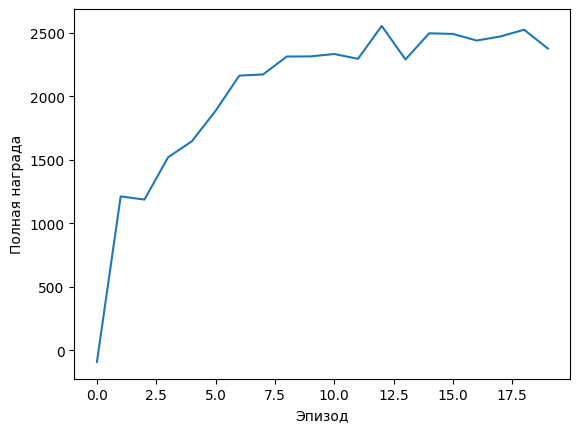

In [ ]:
plt.ylabel('Полная награда')
plt.xlabel('Эпизод')
plt.plot([rewards[e] for e in rewards.keys()])

### Визуализация результатов стратегии покупки/продажи

Нарисуем график, иллюстрирующий места покупки и продажи

In [ ]:
state = 0
acts = np.zeros(nr_states)
done = False

while(done != True):

        action = choose_action(state)
        next_state, reward, theta, done = act(state, action, theta, prices)

        acts[state] = action

        total_reward += reward

        if(done):
            break

        state = next_state

In [ ]:
buys_idx = np.where(acts == 0)
wait_idx = np.where(acts == 2)
sell_idx = np.where(acts == 1)

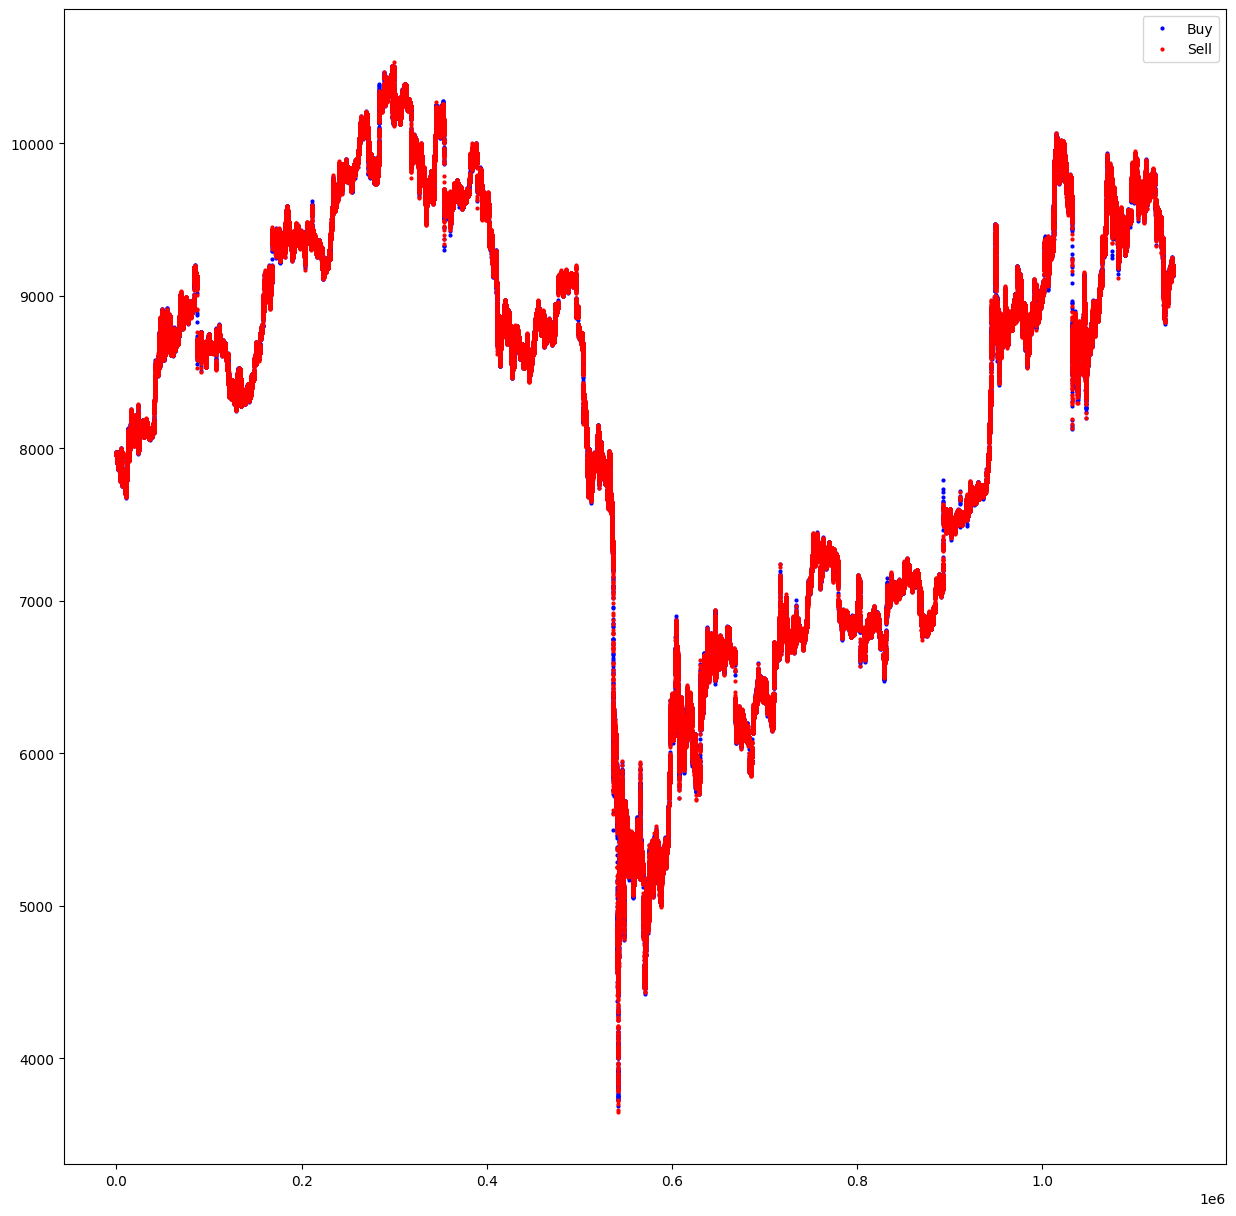

In [ ]:
plt.figure(figsize=(15,15))
plt.plot(buys_idx[0], prices[buys_idx], 'bo', markersize=1, label='Покупка')
plt.plot(sell_idx[0], prices[sell_idx], 'ro', markersize=1, label='Продажа')
plt.legend()

## Тестирование

In [ ]:
prices_new = np.loadtxt('/content/prices_btc_Jan_11_2020_to_Jan_07_2021.txt', dtype=float)
print('Кол-во записей:', len(prices))


Кол-во записей: 1141281


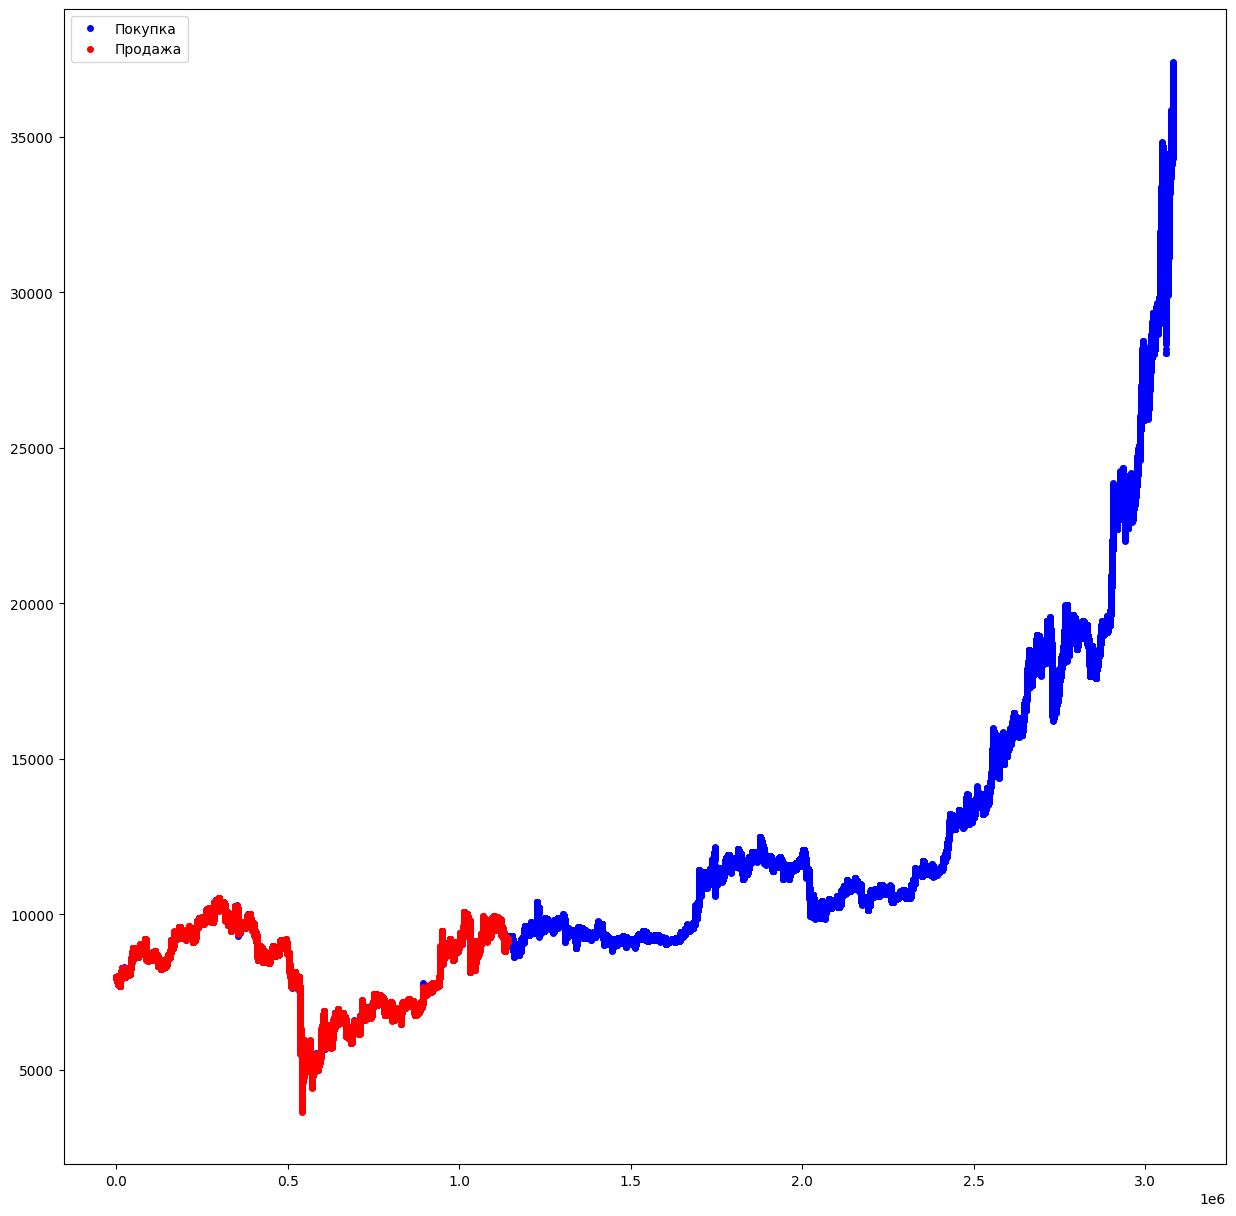

In [ ]:
# Визуализация результатов стратегии покупки/продажи для новых данных

state = 0
acts_new = np.zeros(len(prices_new))
theta_test = 0, 100  # Изначальные состояния (btc, money)
done = False

final_reward = 0

while not done:
    action = choose_action(state)
    next_state, reward, theta_test, done = act(state, action, theta_test, prices_new)
    acts_new[state] = action
    final_reward += reward
    if done:
        break
    state = next_state

buys_idx_new = np.where(acts_new == 0)
wait_idx_new = np.where(acts_new == 2)
sell_idx_new = np.where(acts_new == 1)

plt.figure(figsize=(15,15))
plt.plot(buys_idx_new[0], prices_new[buys_idx_new], 'bo', markersize=1, label='Покупка')
plt.plot(sell_idx_new[0], prices_new[sell_idx_new], 'ro', markersize=1, label='Продажа')
plt.legend()

In [ ]:
final_reward

2346